<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-и-анализ-данных" data-toc-modified-id="Загрузка-и-анализ-данных-1">Загрузка и анализ данных</a></span></li><li><span><a href="#Векторный-поиск-ближайших-соседей" data-toc-modified-id="Векторный-поиск-ближайших-соседей-2">Векторный поиск ближайших соседей</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3">Выводы</a></span></li></ul></div>

# Векторный поиск в задаче матчинга

**Матчинг продуктов:**  
Конечная цель матчинга заключается в определении, являются ли два или более предмета эквивалентными или одним и тем же объектом.

В контексте задачи матчинга в базе данных (base) хранится информация о продуктах, которые могут быть предложены для покупки. Запрос (query) представляет из себя набор конкретных продуктов, для которых необходимо найти соответствие в базе данных.
Задача состоит в том, чтобы автоматически сопоставить запрос с подходящим элементом из базы данных и предоставить пользователю наиболее релевантный результат. Это позволяет снизить дублирование товаров и упростить процесс управления продуктами, что способствует увеличению эффективности и экономии времени.

**Цель проекта:** реализовать векторный поиск - поиск ближайших N товаров из коллекции base для каждого товара из query.

**Ход решения:**
- загрузка, анализ и подготовка данных
- реализация векторного поиска с помощтю библиотеки [FAISS](https://github.com/facebookresearch/faiss/wiki)
- выводы


Проект выполнен в рамках [воркшопа](https://www.kaggle.com/competitions/samokattechworkshop/overview) от компании [Samokat.tech](https://samokat.tech/).

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import faiss

from matplotlib import pyplot as plt
%matplotlib inline

pd.options.display.float_format = '{:,.3f}'.format

np.random.seed(0)

## Загрузка и анализ данных

Загрузка данных

In [2]:
base = pd.read_csv('base.csv', index_col='Id').astype('float32')
test = pd.read_csv('test.csv', index_col='Id').astype('float32')

base_ids = pd.read_csv('base.csv', usecols=['Id'])
test_ids = pd.read_csv('test.csv', usecols=['Id'])

Проверим данные методом info(), выведем первые строки таблиц.

In [3]:
print(base.info())
base.head()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
 3   3       float32
 4   4       float32
 5   5       float32
 6   6       float32
 7   7       float32
 8   8       float32
 9   9       float32
 10  10      float32
 11  11      float32
 12  12      float32
 13  13      float32
 14  14      float32
 15  15      float32
 16  16      float32
 17  17      float32
 18  18      float32
 19  19      float32
 20  20      float32
 21  21      float32
 22  22      float32
 23  23      float32
 24  24      float32
 25  25      float32
 26  26      float32
 27  27      float32
 28  28      float32
 29  29      float32
 30  30      float32
 31  31      float32
 32  32      float32
 33  33      float32
 34  34      float32
 35  35      float32
 36  36      float32
 37  37      float32
 38  38      float32
 39  39      float32


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.084,11.153,-64.427,-118.881,216.482,-104.698,-469.071,44.348,120.915,181.450,...,-42.809,38.801,-151.762,-74.389,63.666,-4.704,92.934,115.269,-112.757,-60.830
1-base,-34.562,13.333,-69.788,-166.533,57.681,-86.098,-85.077,-35.637,119.719,195.234,...,-117.768,41.100,-157.829,-94.447,68.202,24.347,179.938,116.834,-84.889,-59.525
2-base,-54.234,6.379,-29.210,-133.414,150.896,-99.435,52.555,62.382,128.951,164.381,...,-76.398,46.012,-207.144,127.326,65.566,66.326,81.073,116.594,"-1,074.465",-32.527
3-base,-87.520,4.038,-87.803,-185.068,76.370,-58.985,-383.183,-33.611,122.032,136.234,...,-70.648,-6.359,-147.201,-37.693,66.203,-20.567,137.207,117.474,"-1,074.465",-72.915
4-base,-72.744,6.522,43.671,-140.608,5.820,-112.074,-397.711,45.182,122.167,112.119,...,-57.199,56.642,-159.352,85.945,66.766,-2.506,65.315,135.052,"-1,074.465",0.319


In [4]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float32
 1   1       100000 non-null  float32
 2   2       100000 non-null  float32
 3   3       100000 non-null  float32
 4   4       100000 non-null  float32
 5   5       100000 non-null  float32
 6   6       100000 non-null  float32
 7   7       100000 non-null  float32
 8   8       100000 non-null  float32
 9   9       100000 non-null  float32
 10  10      100000 non-null  float32
 11  11      100000 non-null  float32
 12  12      100000 non-null  float32
 13  13      100000 non-null  float32
 14  14      100000 non-null  float32
 15  15      100000 non-null  float32
 16  16      100000 non-null  float32
 17  17      100000 non-null  float32
 18  18      100000 non-null  float32
 19  19      100000 non-null  float32
 20  20      100000 non-null  float32
 21

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.373,3.598,-13.214,-125.927,110.746,-81.280,-461.003,139.816,112.881,75.216,...,-75.513,52.831,-143.439,59.052,69.282,61.928,111.593,115.141,"-1,099.130",-117.079
100001-query,-53.759,12.790,-43.269,-134.418,114.450,-90.520,-759.626,63.995,127.118,53.129,...,-79.442,29.185,-168.606,-82.872,70.766,-65.976,97.077,123.392,-744.442,-25.009
100002-query,-64.175,-3.981,-7.679,-170.161,96.446,-62.378,-759.626,87.478,131.270,168.920,...,-134.795,37.369,-159.662,-119.233,67.710,86.002,137.636,141.082,-294.052,-70.970
100003-query,-99.287,16.124,9.837,-148.060,83.697,-133.730,58.576,-19.047,115.042,75.207,...,-77.236,44.100,-132.530,-106.319,70.884,23.578,133.184,143.253,-799.364,-89.393
100004-query,-79.533,-0.364,-16.027,-170.885,165.454,-28.292,33.932,34.411,128.904,102.087,...,-123.770,45.636,-134.259,13.735,70.618,15.332,154.568,101.701,"-1,171.892",-125.308


Во всех колонках одинаковое количество значений - пропусков нет. Обе таблицы имеют одинаковую структуру и одинаковое количество столбцов. Выведем статистическую информацию о таблицах с помощью describe()

In [5]:
base.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,"2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000",...,"2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000","2,918,139.000"
mean,-86.229,8.080,-44.581,-146.635,111.317,-71.991,-392.224,20.353,123.684,124.458,...,-79.023,33.297,-154.796,14.151,67.792,23.545,74.959,115.567,-799.339,-47.791
std,24.891,4.953,38.632,19.845,46.348,28.186,271.655,64.216,6.356,64.431,...,30.456,28.886,41.229,98.951,1.823,55.342,61.345,21.175,385.413,41.748
min,-199.469,-13.915,-240.073,-232.667,-105.583,-211.009,-791.470,-301.860,93.153,-173.872,...,-220.566,-88.508,-353.903,-157.594,59.509,-233.138,-203.602,15.724,"-1,297.932",-226.780
25%,-103.065,4.708,-69.559,-159.905,80.508,-91.380,-629.332,-22.221,119.484,81.768,...,-98.764,16.989,-180.780,-71.300,66.581,-12.516,33.776,101.687,"-1,074.465",-75.666
50%,-86.231,8.039,-43.817,-146.777,111.873,-71.922,-422.202,20.805,123.892,123.498,...,-78.488,34.715,-153.977,13.827,67.815,23.416,74.930,116.024,"-1,074.465",-48.592
75%,-69.257,11.470,-19.625,-133.328,142.374,-52.441,-156.669,63.918,127.970,167.221,...,-58.534,52.164,-127.340,99.668,69.027,59.755,115.876,129.552,-505.744,-19.714
max,21.516,29.937,160.937,-51.375,319.664,58.806,109.633,341.228,152.261,427.542,...,60.174,154.168,24.361,185.098,75.712,314.899,339.574,214.706,98.771,126.973


In [6]:
test.describe()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,"100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000",...,"100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000","100,000.000"
mean,-85.302,7.670,-43.842,-146.120,111.635,-73.273,-441.397,21.594,123.078,126.001,...,-81.129,36.779,-152.341,14.398,67.789,23.251,73.114,115.197,-709.457,-48.416
std,25.777,4.957,39.139,20.496,47.752,28.516,279.243,66.478,6.505,64.982,...,30.692,25.427,41.246,98.695,1.845,55.404,62.056,21.493,405.666,41.293
min,-190.353,-11.110,-217.538,-220.051,-81.199,-176.705,-791.460,-265.608,96.218,-135.667,...,-215.152,-66.266,-337.633,-157.594,60.378,-210.673,-175.922,25.271,"-1,297.924",-209.936
25%,-103.232,4.292,-69.681,-160.210,79.102,-92.790,-740.620,-21.805,118.658,82.311,...,-101.690,19.564,-179.115,-70.420,66.546,-13.863,31.495,100.539,"-1,074.465",-76.359
50%,-85.297,7.658,-43.231,-146.080,111.959,-73.579,-513.923,22.138,123.063,126.084,...,-81.027,36.414,-151.426,14.768,67.800,23.509,72.152,115.281,-807.030,-48.670
75%,-67.422,10.994,-17.766,-132.119,143.904,-53.861,-202.572,66.098,127.539,169.680,...,-60.275,53.888,-124.400,99.804,69.041,60.155,114.317,129.770,-358.400,-20.283
max,14.428,27.410,134.860,-57.382,302.065,50.255,109.632,279.469,151.823,392.827,...,41.390,141.025,14.602,185.094,75.400,251.289,305.938,201.600,98.737,111.832


Проверим данные на наличие дубликатов

In [7]:
base.duplicated().sum(), test.duplicated().sum()

(0, 0)

Дубликатов в таблицах нет.  
Посмотрим на распределение каждого признака.

/home/alina/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


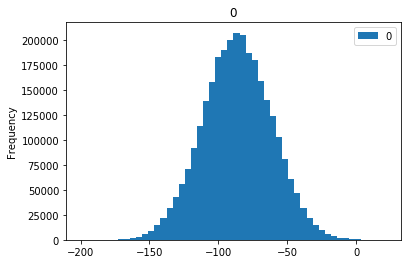

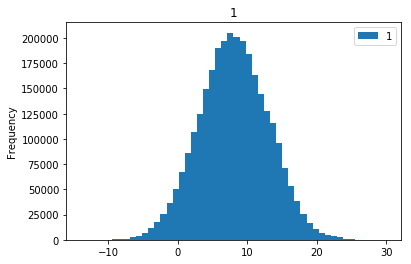

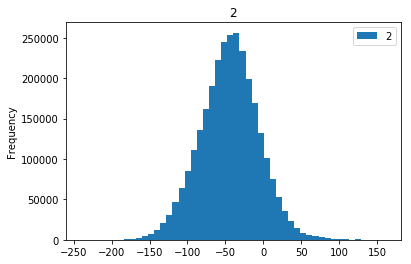

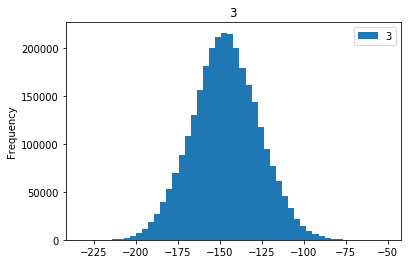

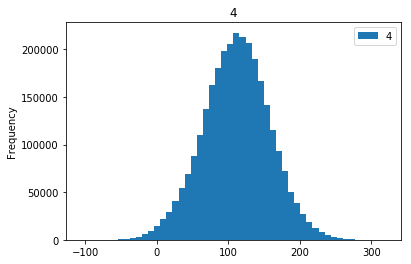

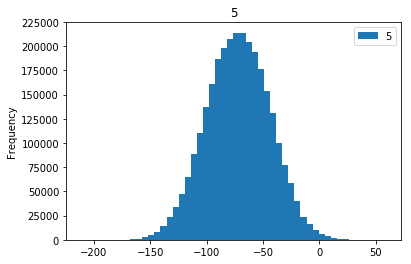

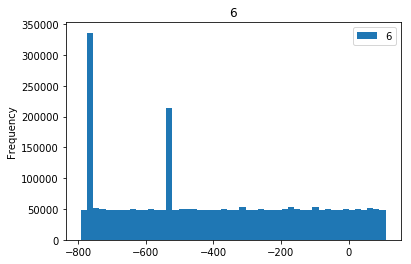

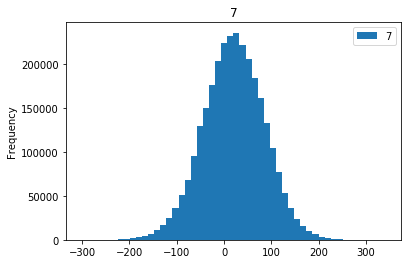

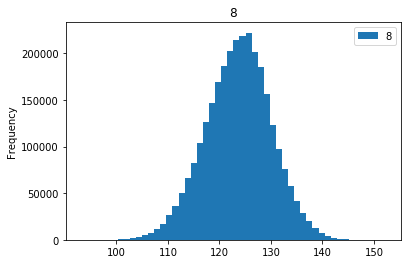

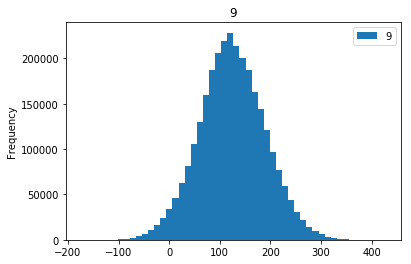

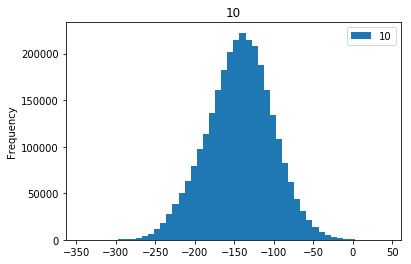

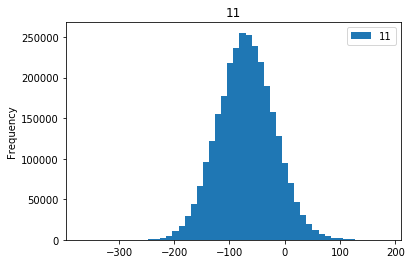

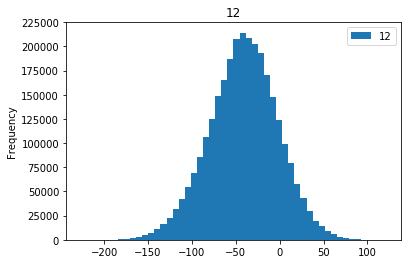

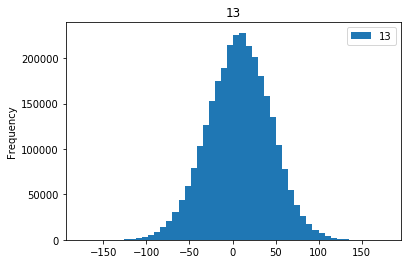

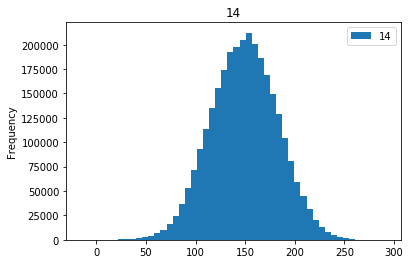

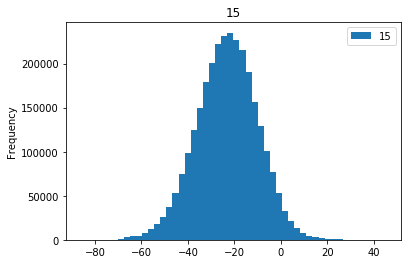

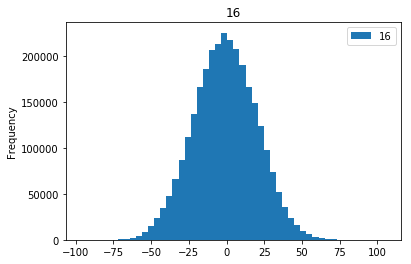

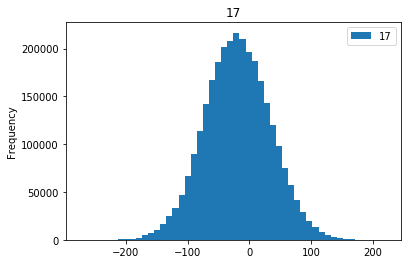

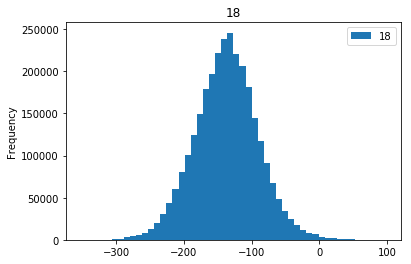

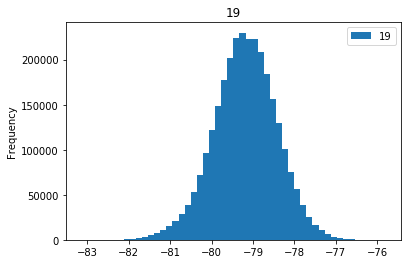

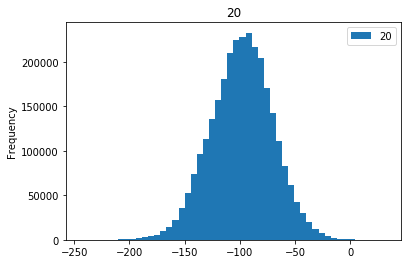

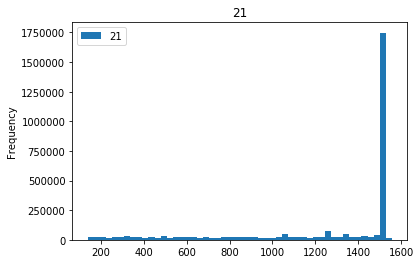

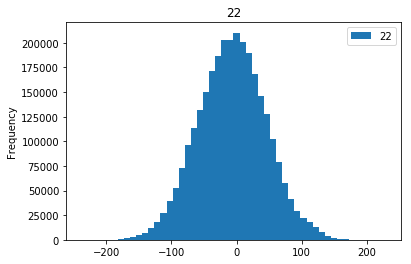

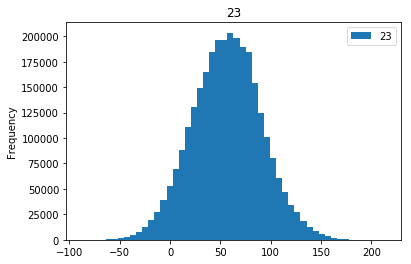

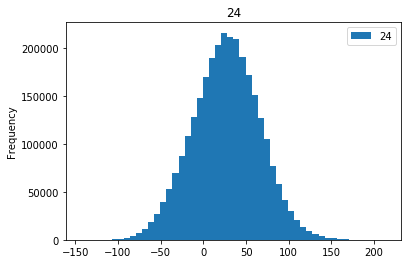

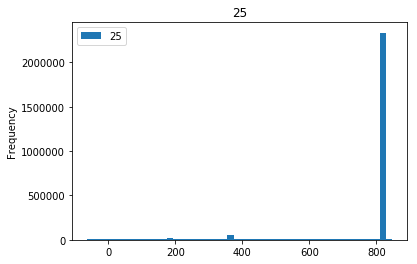

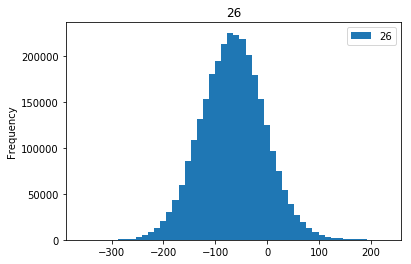

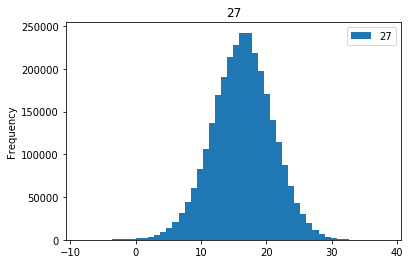

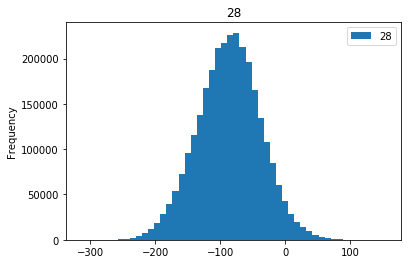

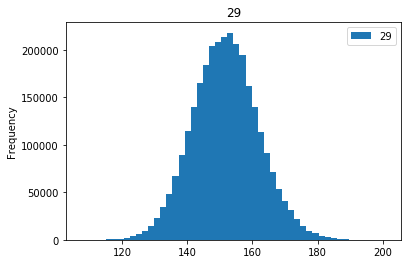

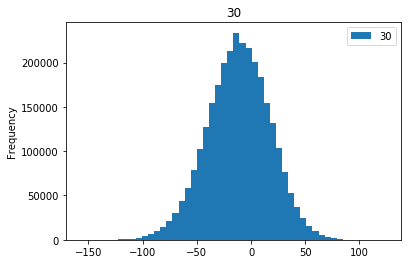

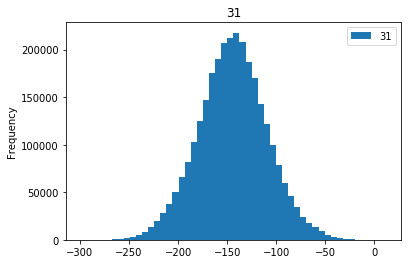

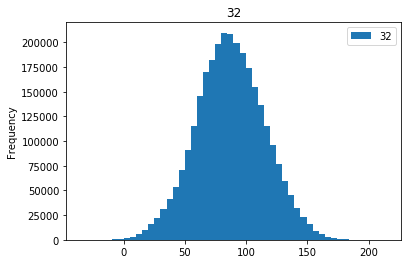

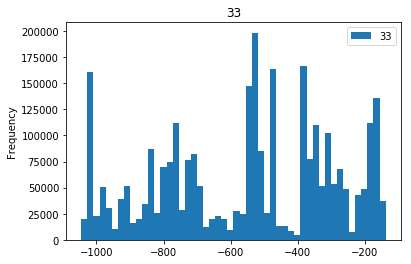

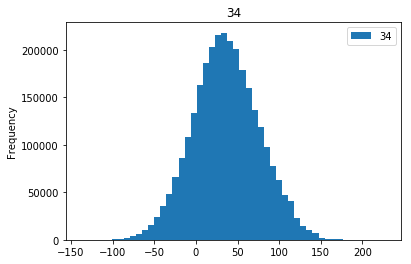

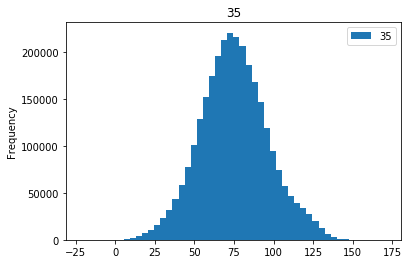

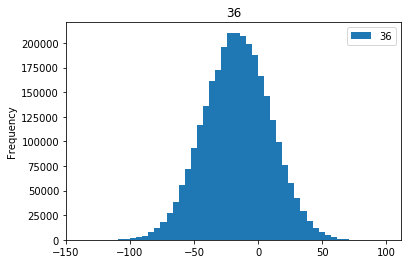

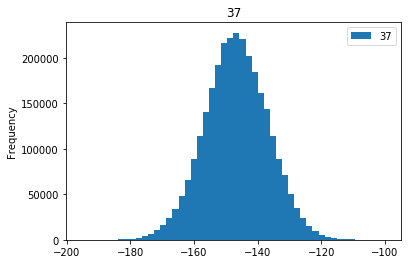

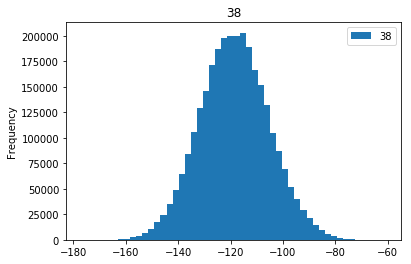

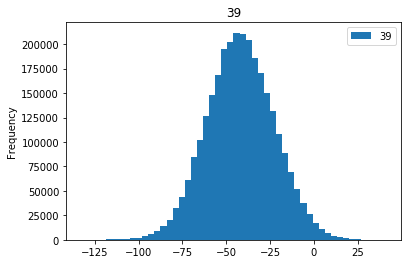

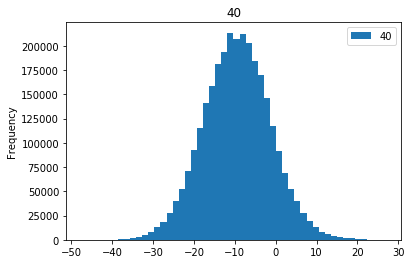

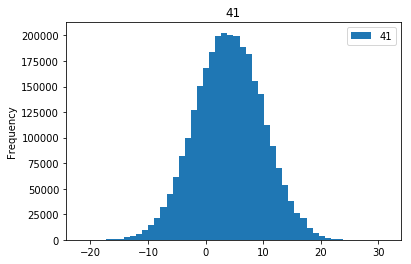

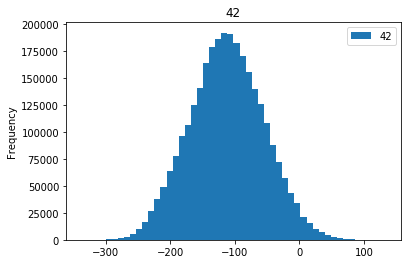

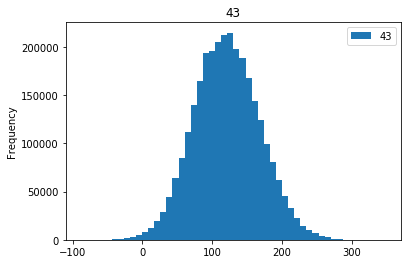

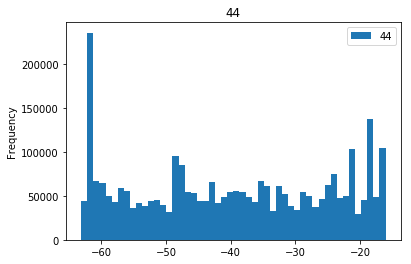

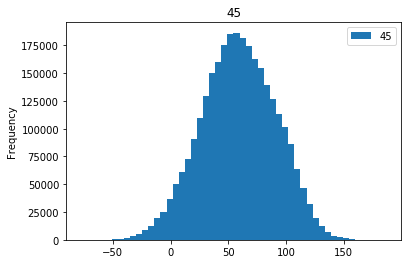

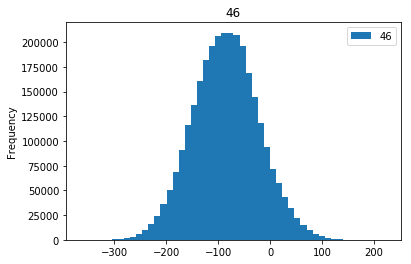

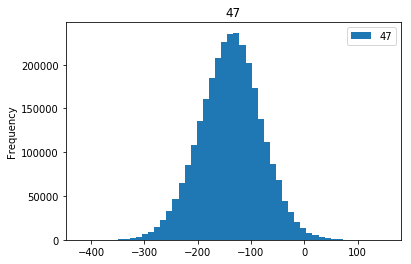

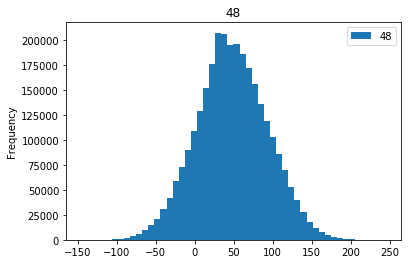

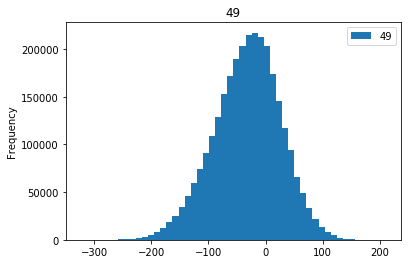

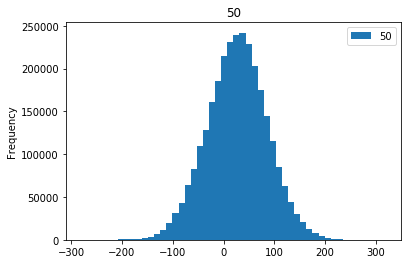

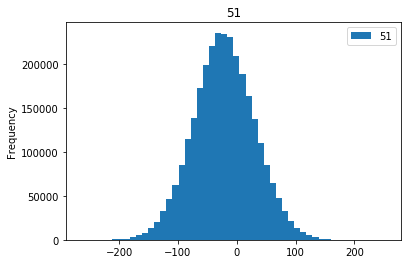

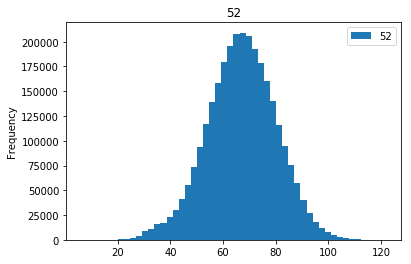

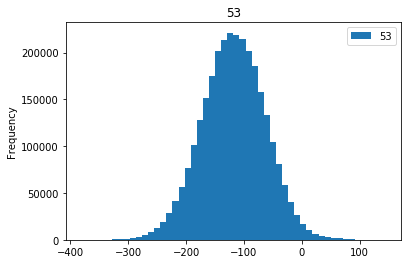

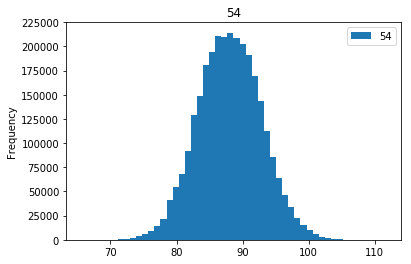

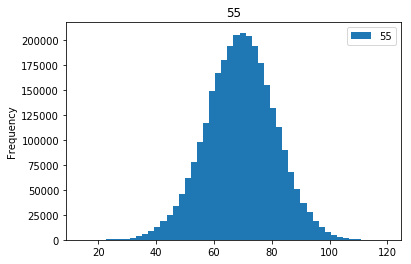

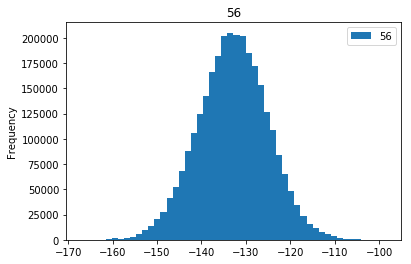

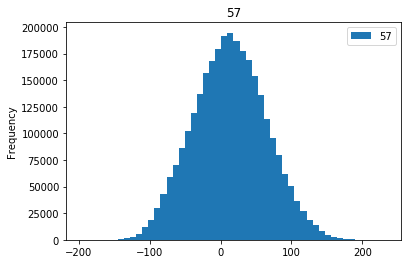

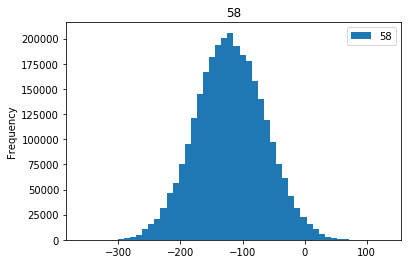

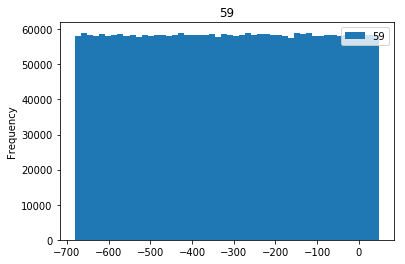

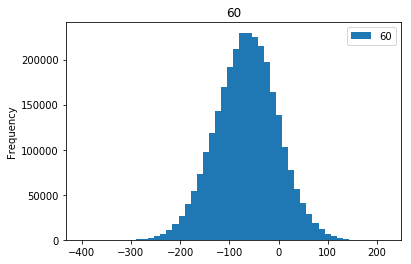

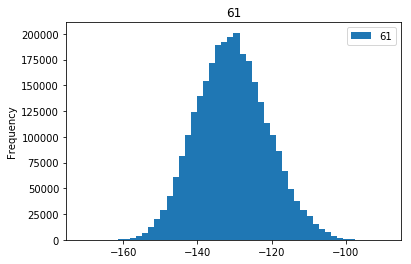

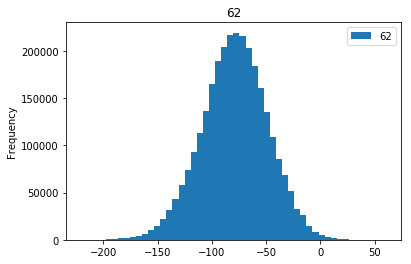

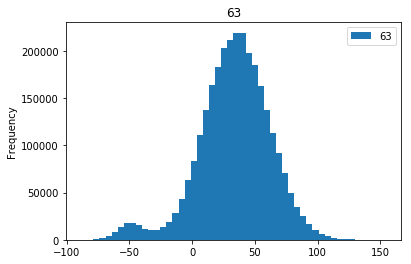

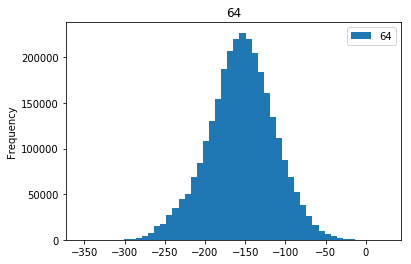

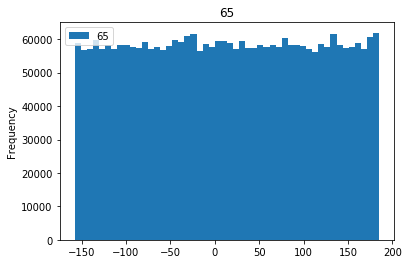

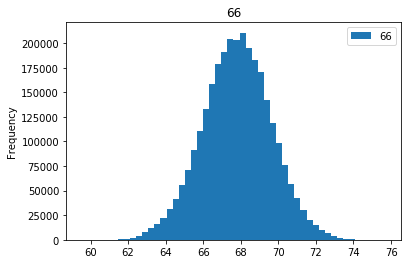

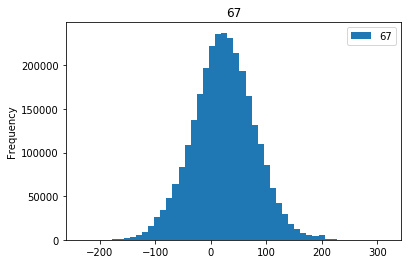

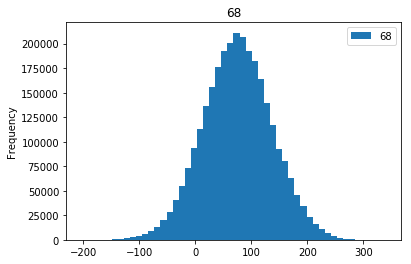

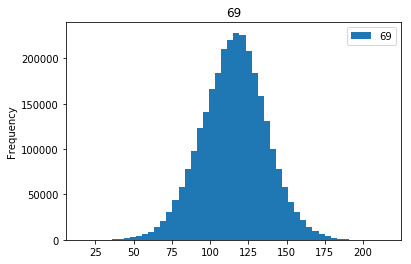

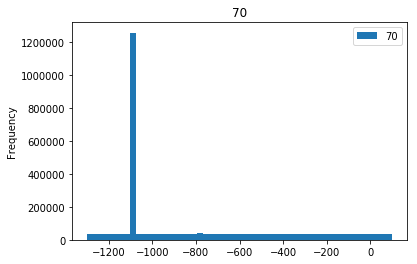

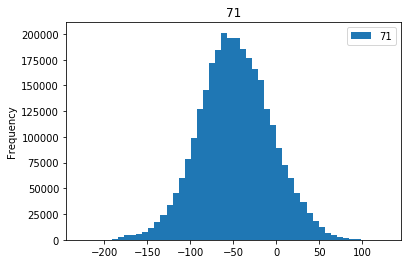

In [8]:
for column in base.columns:
    base.plot(y=column, kind='hist', bins=50, title=column)

/home/alina/.local/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


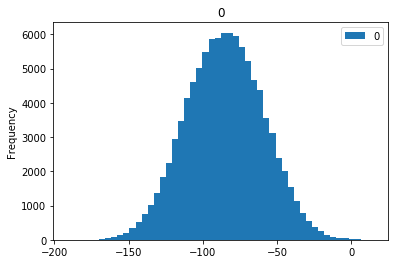

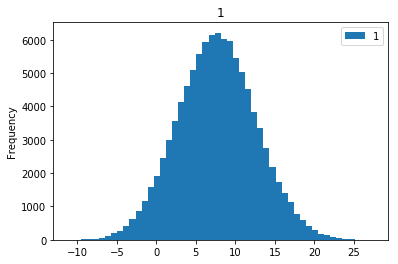

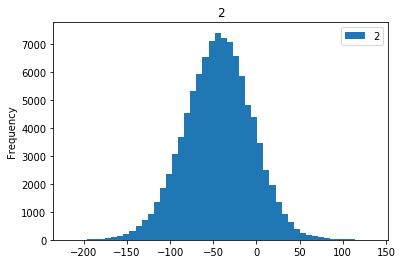

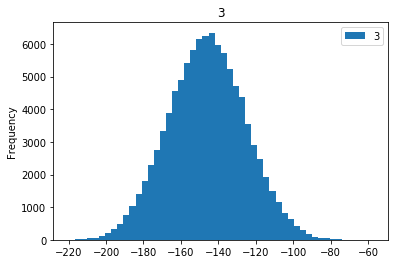

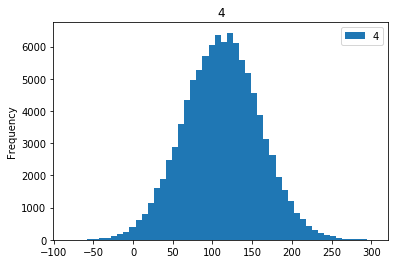

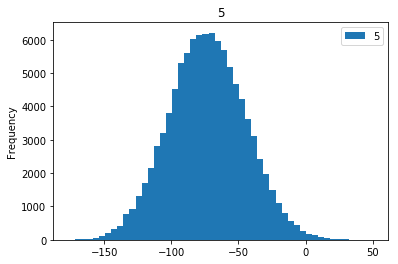

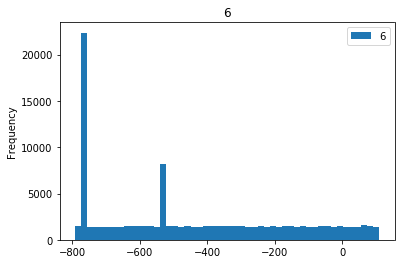

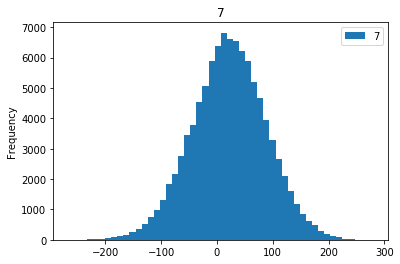

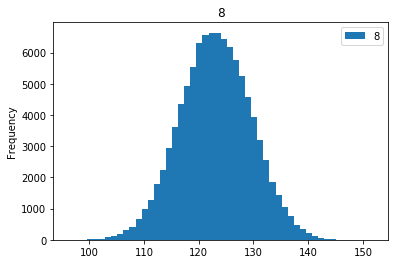

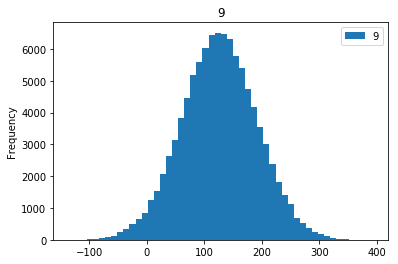

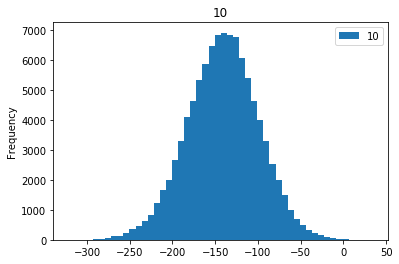

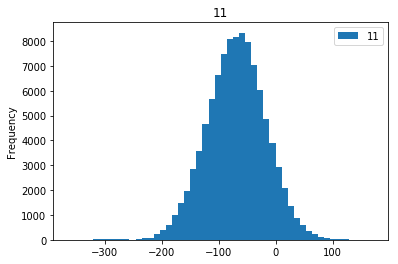

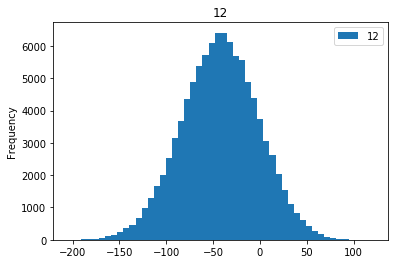

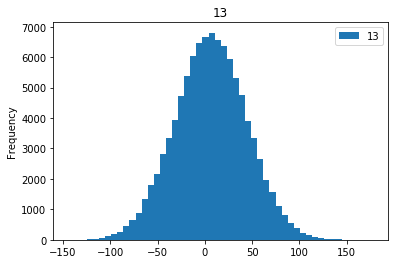

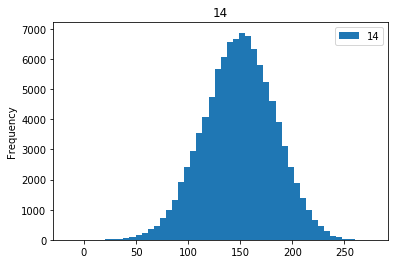

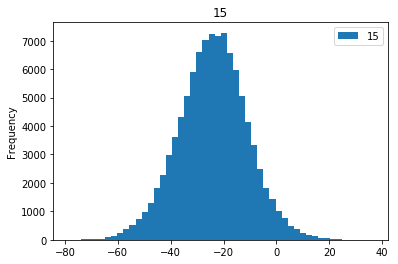

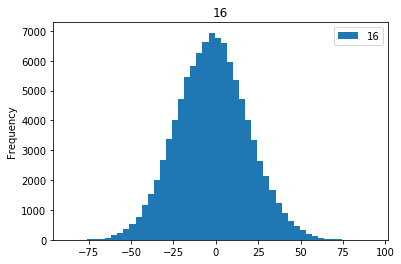

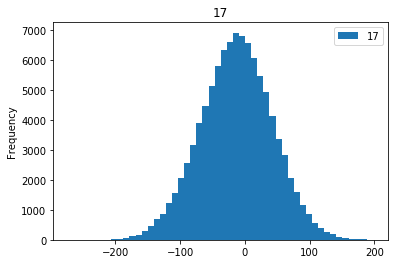

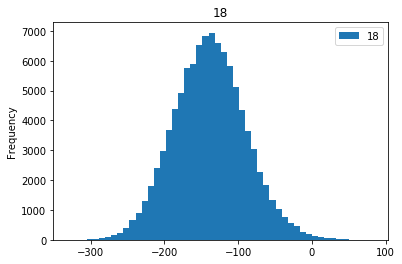

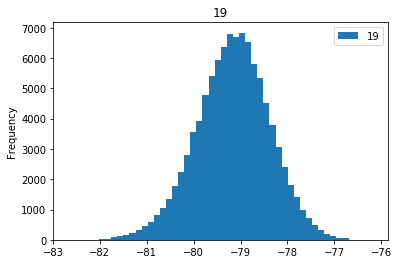

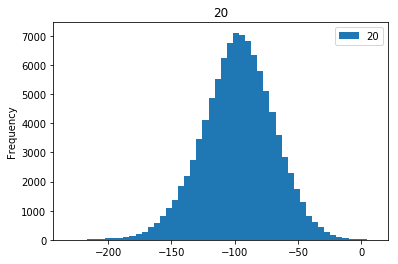

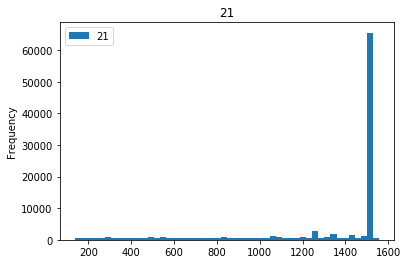

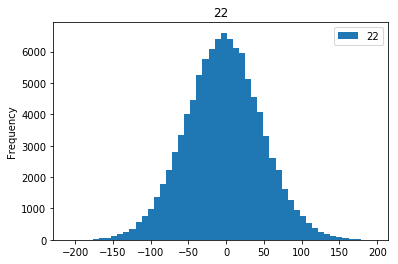

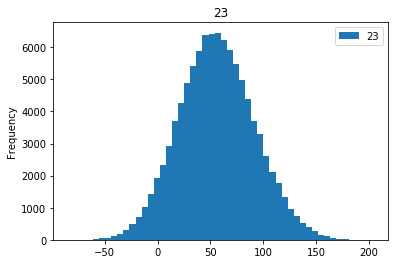

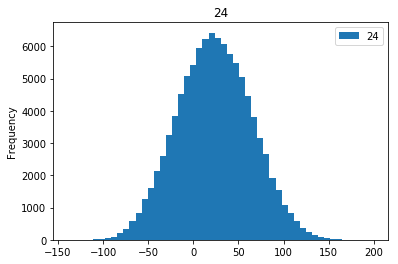

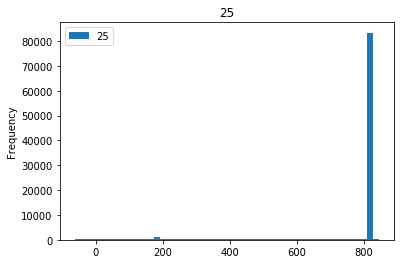

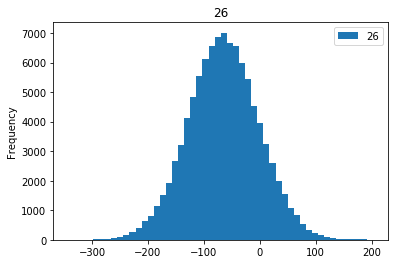

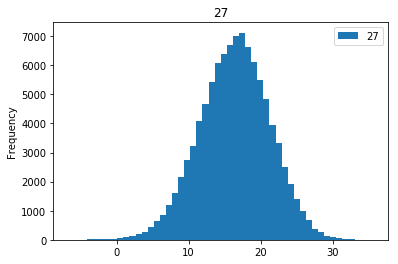

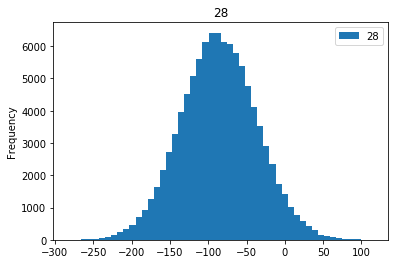

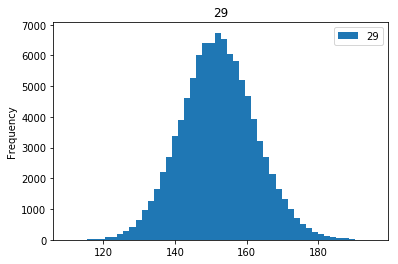

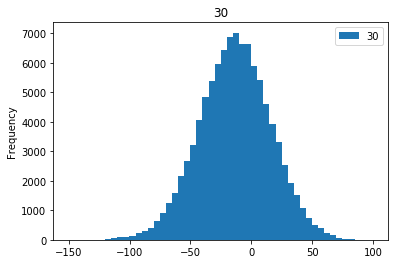

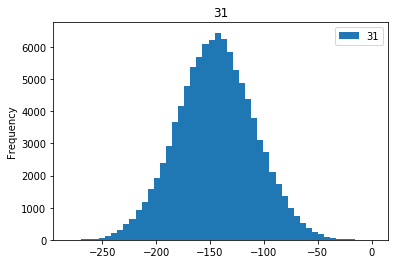

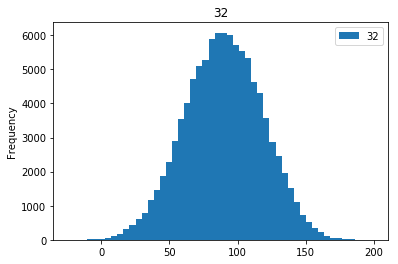

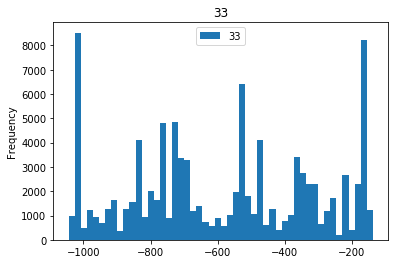

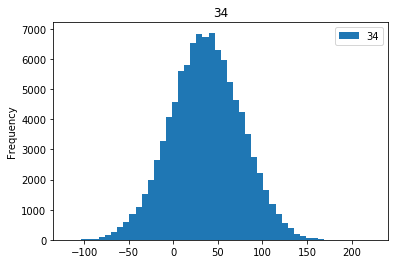

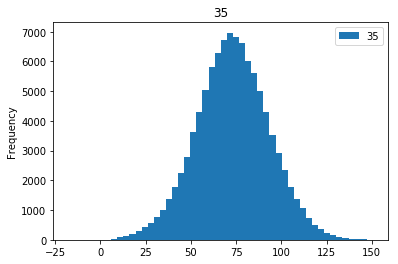

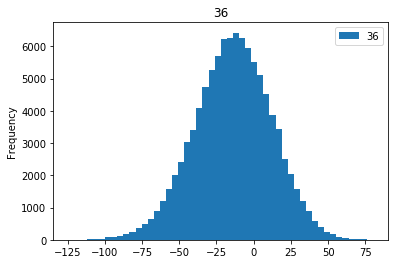

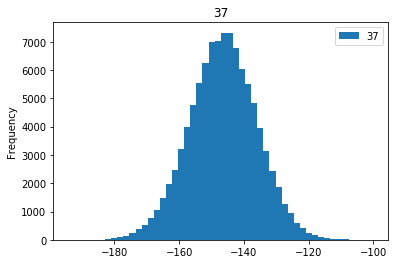

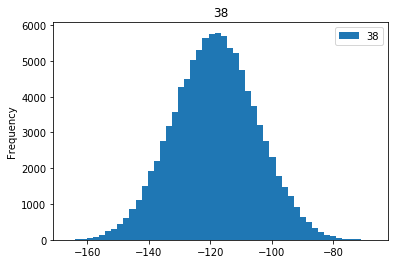

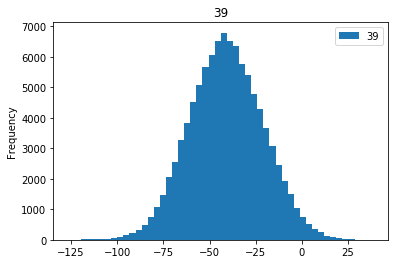

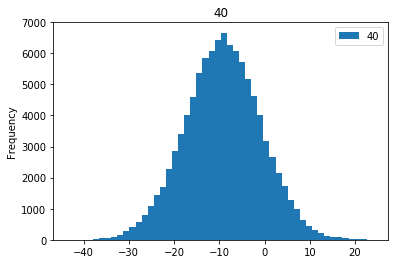

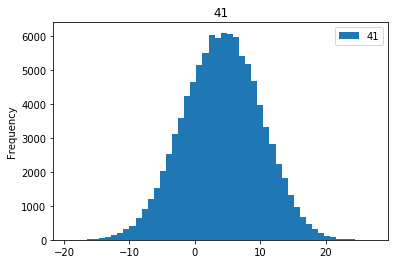

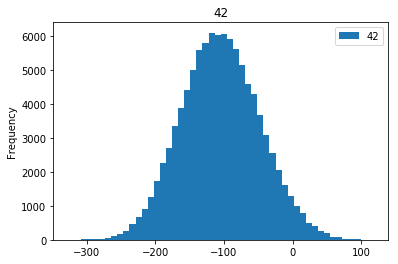

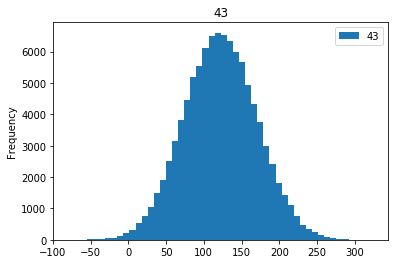

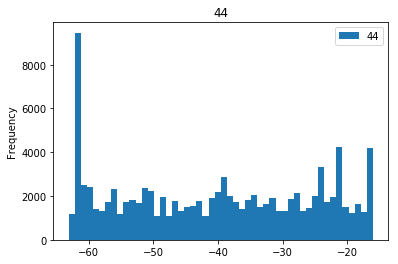

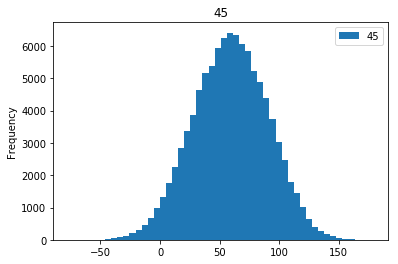

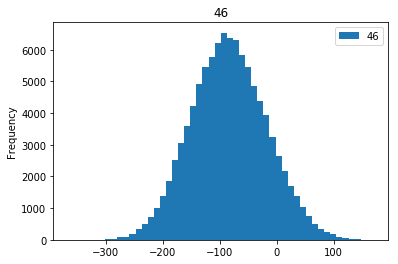

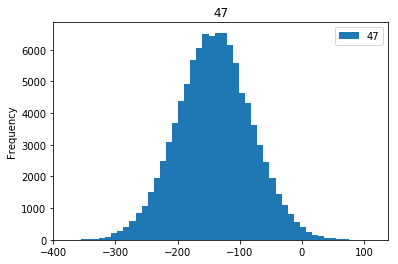

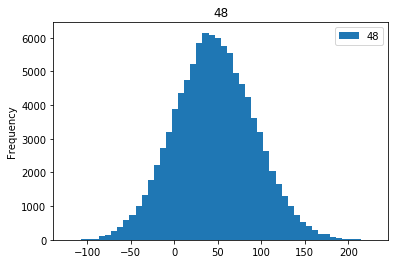

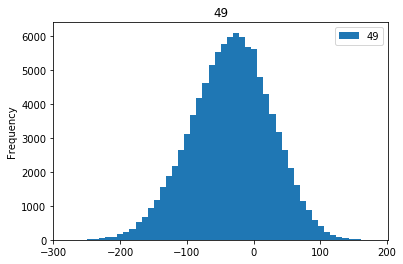

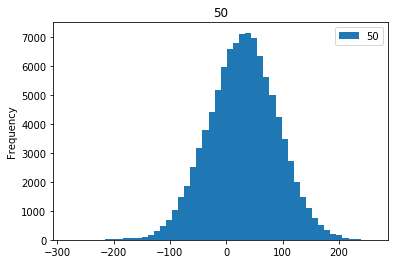

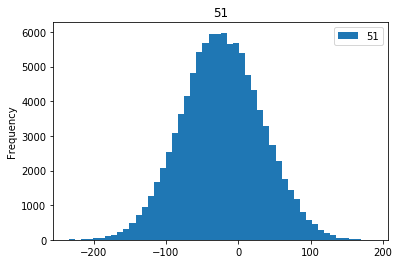

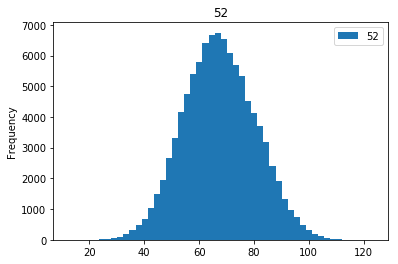

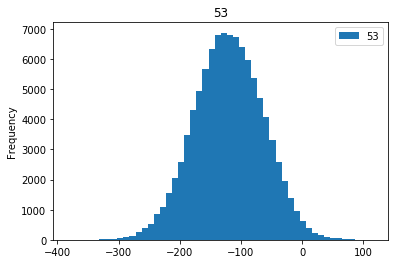

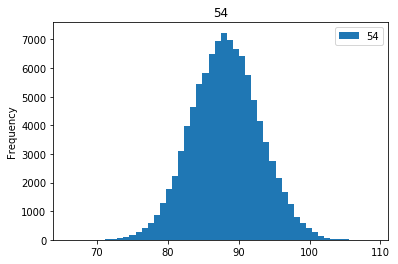

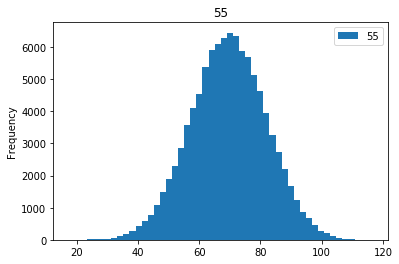

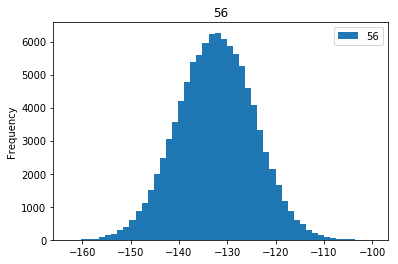

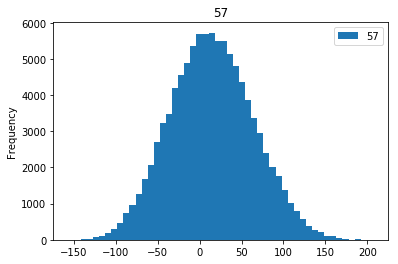

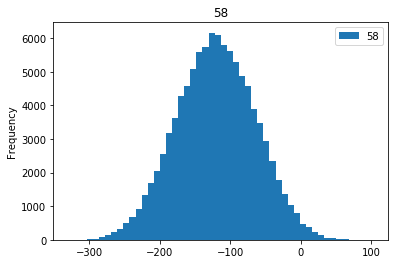

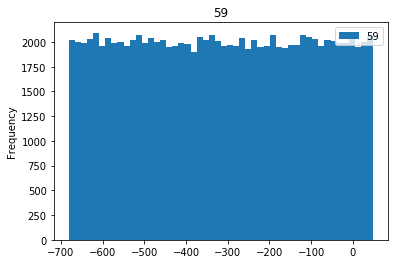

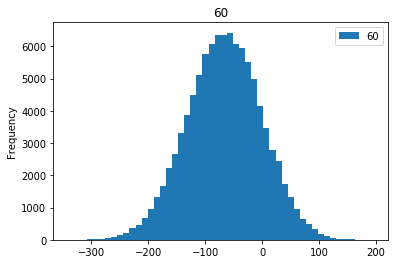

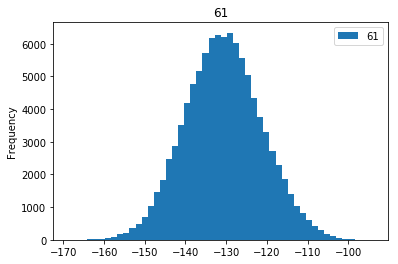

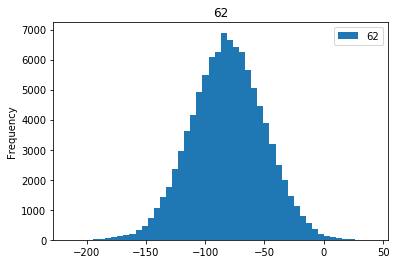

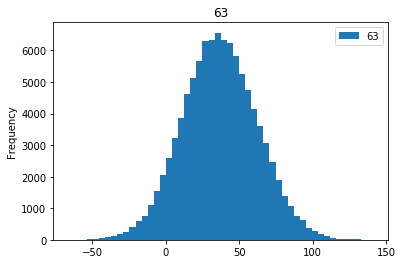

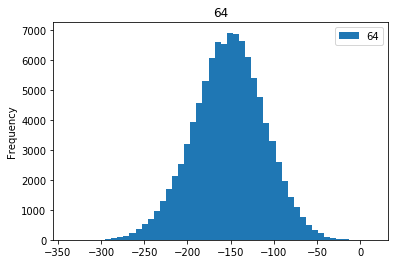

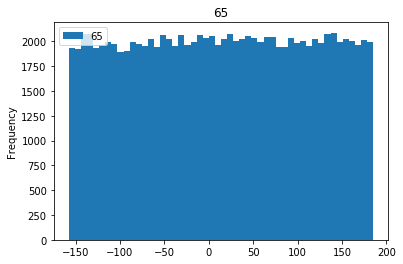

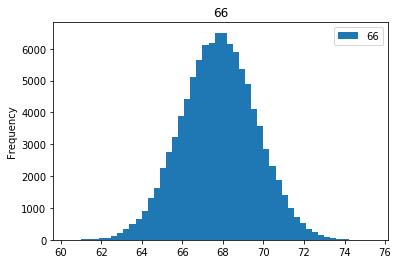

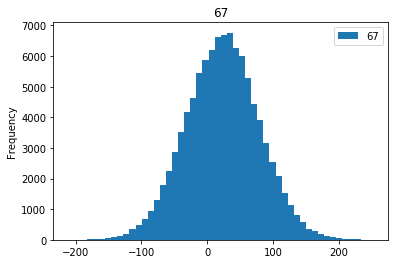

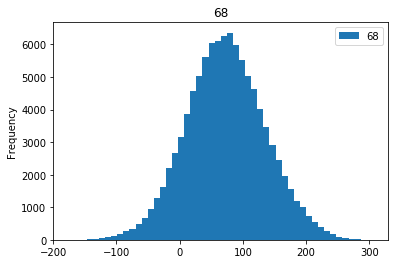

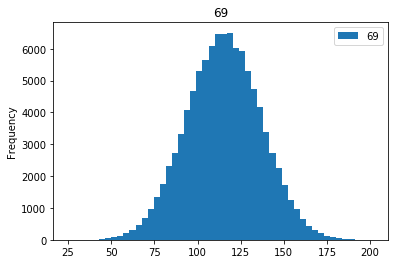

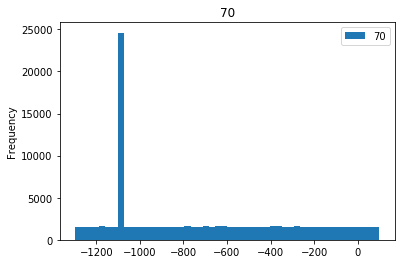

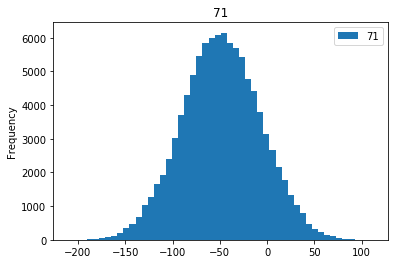

In [9]:
for column in test.columns:
    test.plot(y=column, kind='hist', bins=50, title=column)

Практически все признаки нормально распределены, но встречаются признаки с равномерным распределением или с пиковыми значениями в одном или паре значений. Выделим такие признаки и удалим их из таблиц, поскольку с данными признаками качество поиска ближайших соседей значительно снижается (recal@10 на полном наборе данных не превышает 0.15).

In [10]:
columns = ['6', '21', '25', '59', '65', '70', '33', '44']

In [11]:
base = base.drop(columns=columns)

In [12]:
test = test.drop(columns=columns)

Масштабируем признаки и преобразуем их в нужный формат для работы с Faiss.

In [13]:
base = base.to_numpy().astype('float32')


In [14]:
test = test.to_numpy().astype('float32')

In [15]:
scaler = StandardScaler()
scaler.fit(base)
base = scaler.transform(base)
test = scaler.transform(test)

In [16]:
base=np.ascontiguousarray(base)
test=np.ascontiguousarray(test)

## Векторный поиск ближайших соседей

Далее поиск 10 ближайших соседей будем осуществлять с помощью библиотеки Faiss.

In [17]:
d = base.shape[1]               # размерность индекса

nb = base.shape[0]             # количество строк в base 
nq = test.shape[0]             # количесвто запросов в test 


nlist = 2000  # количество кластеров, на которые будем делить base для более выстрого поиска (~sqrt(nb))

# создадим индекс, в качестве метрики используем косинусное расстояние
quantiser = faiss.IndexFlatIP(d)  
index = faiss.IndexIVFFlat(quantiser, d, nlist,   
                           faiss.METRIC_INNER_PRODUCT)

In [18]:
print(index.is_trained)   # False

faiss.normalize_L2(base) # нормализуем base для расчета косинусного расстояния
index.train(base)  # обучение на векторах base 

print(index.ntotal)   # проверяем, что индекс пустой
index.add(base)   # добавляем вектора и обновляем индекс
print(index.is_trained)  # True
print(index.ntotal)   # проверяем, что вектора из base добавлены

False
0
True
2918139


In [19]:
k = 10 # количество ближайших объектов для поиска
index.nprobe = 50 # количество кластеров-соседей, которые будем рассматривать при поиске (~sqrt(nlist))
faiss.normalize_L2(test)

In [20]:
%%time

# осуществляем поиск k-ближайших соседей для каждой записи в test
distances, indices = index.search(test, k)

CPU times: user 6min 28s, sys: 2.05 s, total: 6min 30s
Wall time: 1min 39s


In [21]:
indices

array([[1954150, 2192372, 1225777, ...,  340288, 2177660, 1405698],
       [1902634,  157966, 2528494, ..., 1884931, 2123768,  489609],
       [ 431806,  451870,   24989, ...,  208180, 1706372, 1139764],
       ...,
       [1392746, 1731267, 2249505, ...,  232504,  209755,  135023],
       [ 319526,   77792, 2820290, ..., 2253420, 2830835,  392111],
       [1537302, 1811737,  315821, ...,  234056,  133651, 1209429]])

Оформим результаты в таблицу, сопоставим найденные индексы с Id товара.

In [22]:
test_ids['Predicted'] = ''

In [23]:
for i in range(len(test)):
    prediction = indices[i]
    test_ids.loc[i, 'Predicted'] = ' '.join([base_ids.loc[k, 'Id'] for k in prediction])

In [24]:
test_ids

,Id,Predicted
0,100000-query,2760762-base 3209652-base 1542803-base 3839597...
1,100001-query,2666508-base 163485-base 3890545-base 11853-ba...
2,100002-query,472256-base 496010-base 25113-base 153272-base...
3,100003-query,3168654-base 1831175-base 2345993-base 4473809...
4,100004-query,1217188-base 75484-base 2366033-base 2863148-b...
...,...,...
99995,199995-query,250053-base 880713-base 4388368-base 2167458-b...
99996,199996-query,272706-base 2653840-base 220273-base 936053-ba...
99997,199997-query,1801591-base 2362444-base 3321919-base 654974-...
99998,199998-query,341779-base 79148-base 4523822-base 4091212-ba...


Сохраним полученную таблицу в файл.

In [25]:
test_ids.to_csv('answer.csv', index=False)

## Выводы

Данное решение выполняет поиск 10 ближайших соседей примерно за полторы минуты и даёт значение метрики recall@10 = 0.73.

При решении задачи также были исследованы корреляции между данными, мультиколлинеарных признаков обнаружено не было. Были испробованы разные комбинации удаления "проблемных" столбцов, и максимальная метрика была достигнута при удалении всех столбцов, чьи распределения значений отличались от нормального распределения. Также были испробованы разные параметры index.nprobe и nlist - максимальные значения метрики были получены при значния этих параметров равных 50 и 2000 соответсвенно.

Варианты улучшения векторного поиска: 
- попробовать другие индексы FAISS (например, HNSW, IVFPQ)
- воспользоваться тренировочной выборкой, обучить на ней [CatBoostRanker](https://github.com/catboost/catboost/blob/master/catboost/tutorials/ranking/ranking_tutorial.ipynb), затем применить FAISS для поиска 100 ближайших соседей. Из 100 отобранных соседей выбрать наиболее близкие 10 соседей с помощью обученной модели CatBoostRanker